<a href="https://colab.research.google.com/github/MalcolmSlaney/python_auditory_toolbox/blob/main/Audio_Toolbox_Demonstrations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Python Auditory Toolbox Demonstrations
This colab demonstrates the functions in the [Python Auditory Toolbox](https://github.com/MalcolmSlaney/PythonAuditoryToolbox).  Most of these examples are also tests for the Numpy and JAX code.


To import this from GitHub instead of PIP, do the following
```
!rm -rf PythonAuditoryToolbox
!git clone https://github.com/MalcolmSlaney/PythonAuditoryToolbox.git

```

In [1]:
!pip install python_auditory_toolbox

In [2]:
import python_auditory_toolbox.python_auditory_toolbox.auditory_toolbox as pat

In [3]:
import math

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from typing import List

##Test and Example Code

###ERB (Gammatone) Examples

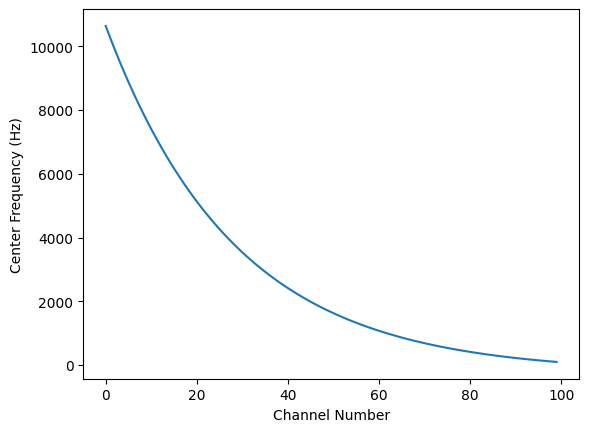

In [4]:
plt.plot(pat.ErbSpace())
plt.xlabel('Channel Number')
plt.ylabel('Center Frequency (Hz)');

In [5]:
fs = 16000
low_freq = 100
num_chan = 10
fcoefs = pat.MakeErbFilters(fs, num_chan, low_freq)
[A0, A11, A12, A13, A14, A2, B0, B1, B2, gain] = fcoefs

In [6]:
chan = num_chan//2
impulse_len = 512
x = np.zeros(impulse_len)
x[0] = 1

In [7]:
# Measure the impulse response of each filter.
y = pat.ErbFilterBank(x, fcoefs)
y.shape

(10, 512)

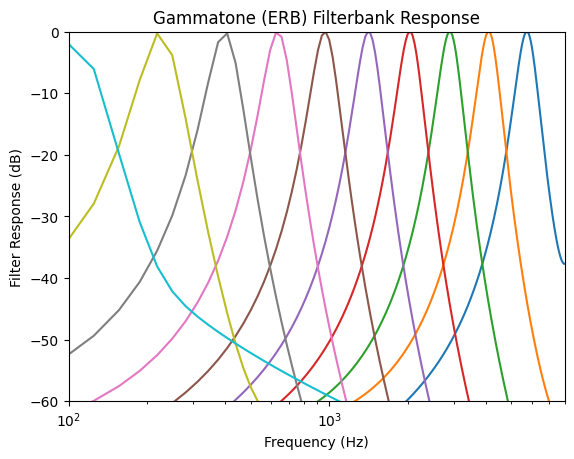

In [8]:
# Plot the frequency response of each filter.
resp = 20*np.log10(np.abs(np.fft.fft(y.T, axis=0)))
plt.semilogx(np.arange(impulse_len)*(fs/impulse_len),
             resp);
plt.xlim(100, fs/2);
plt.ylim(-60, 0)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Filter Response (dB)')
plt.title('Gammatone (ERB) Filterbank Response');

In [9]:
# Make sure the peak locations agree with the Matlab results.
matlab_peak_locs = np.array([184, 132, 94, 66, 46, 32, 21, 14, 8, 4])
python_peak_locs = np.argmax(resp[:impulse_len//2], axis=0)
matlab_peak_locs - python_peak_locs
# Should differ by 1 since Matlab indexes from 1 and Python from 0.

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [10]:
matlab_peak_values = np.array([-0.0097, -0.0000, -0.0013, -0.0264, -0.0517,
                               -0.0301, -0.1953, -0.2937, -0.3083,  -0.8396])
python_peak_values = np.max(resp[:impulse_len//2], axis=0)
matlab_peak_values - python_peak_values

array([-9.33217584e-06,  4.63724132e-05,  3.08646947e-05,  3.68887547e-05,
        2.47284534e-06,  3.84260395e-05,  1.93994868e-05, -4.28007245e-05,
       -2.25626693e-05, -4.91227217e-05])

###Correlogram Tests

array([  0, 100, 200])

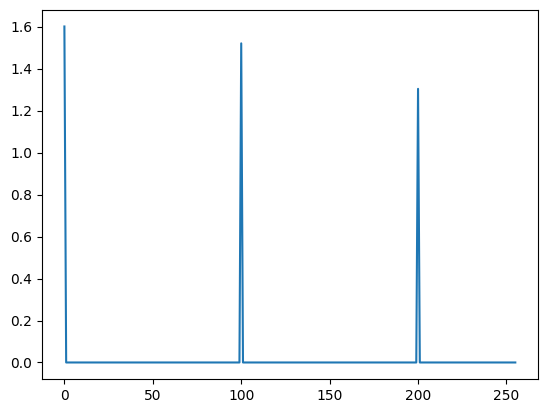

In [11]:
# Make sure we get the right results for an impulse train input.
test_impulses = np.zeros((1,1024))
test_impulses[0, range(0, test_impulses.shape[1], 100)] = 1
test_frame = pat.CorrelogramFrame(test_impulses, 256)
plt.plot(test_frame.T);
np.where(test_frame > 0.1)[1]

In [12]:
fs = 16000
low_freq = 100
num_chan = 64
fcoefs = pat.MakeErbFilters(fs, num_chan, low_freq)

In [13]:
# Show a correlogram frame for a simple harmonic complex.
s = 0
for h in range(1, 10):
  s = s + np.sin(2*np.pi*np.arange(impulse_len)/200*h)

y = pat.ErbFilterBank(s, fcoefs)

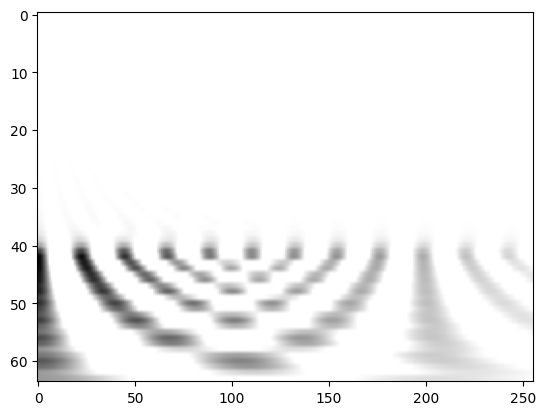

In [14]:
frame = pat.CorrelogramFrame(y, 256)
plt.imshow(np.maximum(0, frame), aspect='auto', cmap='gray_r');

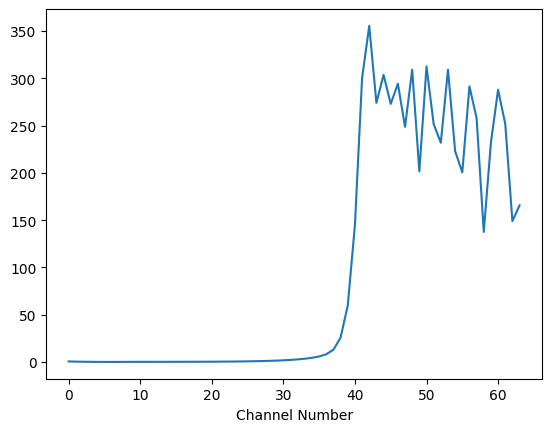

In [15]:
# Plot the energy in each channel
plt.plot(np.sum(frame, 1))
plt.xlabel('Channel Number');

In [16]:
np.argmax(np.sum(frame, 1))

42

In [17]:
np.where(np.sum(frame, 1) < 2)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),)

In [18]:
# Do we get a peak in the lag domain at the right interval?
summary = np.sum(frame, 0)
skip_lags = 100
np.argmax(summary[skip_lags:]) + skip_lags

200

###Vowel Synthesis Tests

In [19]:
points = pat.FMPoints(100000, 160, 10, 20, 16000)

In [20]:
d_points = points[1:] - points[:-1]
np.mean(d_points), np.min(d_points), np.max(d_points)

(99.98780661463458, 87.81880801993248, 112.18119198006752)

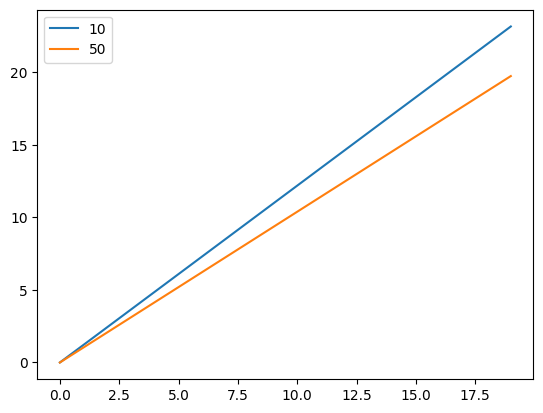

In [21]:
amps = np.arange(20)
deviations = []
for amp in amps:
  points = pat.FMPoints(100000, 160, 10, amp, 16000)
  d_points = points[1:] - points[:-1]
  deviations.append(np.max(d_points) - np.min(d_points))
plt.plot(amps, deviations, label=10)

amps = np.arange(20)
deviations = []
for amp in amps:
  points = pat.FMPoints(100000, 160, 50, amp, 16000)
  d_points = points[1:] - points[:-1]
  deviations.append(np.max(d_points) - np.min(d_points))
plt.plot(amps, deviations, label=50)
plt.legend();
# This test shows that something is wrong with the FM Synthesis.

In [22]:
def local_peaks(x):
  i = np.argwhere(np.logical_and(x[:-2] < x[1:-1],
                                 x[2:] < x[1:-1])) + 1
  return [j[0] for j in i]


local_peaks(np.array([1,2,3,2,1,1,2,2,3,4,1]))[:]

[2, 9]

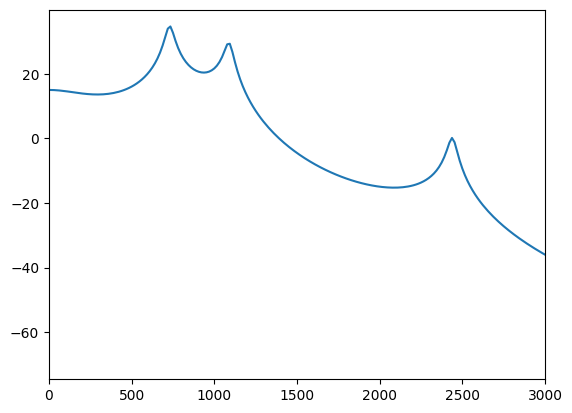

In [23]:
# Synthesize a vowel, and plot the spectrum.
sample_rate = 16000
vowel = pat.MakeVowel(1024, [1,], sample_rate, 'a')
spectrum = 20*np.log10(np.abs(np.fft.fft(vowel)))
freqs = np.arange(len(vowel))*fs/len(vowel)
plt.plot(freqs, spectrum)
plt.xlim(0, 3000);

In [24]:
# Make sure the resulting spectral peaks match the original spec.
freqs[local_peaks(spectrum)[:3]] - np.array([730, 1090, 2440])
# Difference should be less than 5Hz.

array([ 4.375,  3.75 , -2.5  ])

###Correlogram Example

In [25]:
# From https://yaqs.corp.google.com/eng/q/30216778554540032

import base64
import io
import scipy
from IPython import display

def Play(array_of_floats, sample_rate, autoplay=False):
  normalizer = float(np.iinfo(np.int16).max)
  array_of_ints = np.array(
      np.asarray(array_of_floats) * normalizer, dtype=np.int16)
  memfile = io.BytesIO()
  scipy.io.wavfile.write(memfile, sample_rate, array_of_ints)
  html = """<audio controls {autoplay}>
              <source controls src="data:audio/wav;base64,{base64_wavfile}"
                type="audio/wav" />
              Your browser does not support the audio element.
            </audio>"""
  html = html.format(
      autoplay='autoplay' if autoplay else '',
      base64_wavfile=base64.b64encode(memfile.getvalue()).decode('ascii'))
  memfile.close()
  display.display(display.HTML(html))


In [26]:
# Synthesize a trio of synthetic vowels.
vowels = np.concatenate((pat.MakeVowel(10000, 100, 16000,'a'),
                         pat.MakeVowel(10000, 100, 16000,'i'),
                         pat.MakeVowel(10000, 100, 16000,'u')))

In [27]:
Play(vowels/np.max(np.abs(vowels)), 16000)

In [28]:
y = pat.ErbFilterBank(vowels, fcoefs)
vowel_correlogram = pat.CorrelogramArray(y, sr=16000, frame_rate=30, width=256)
vowel_correlogram.shape

(56, 64, 256)

In [29]:
from PIL import Image
import scipy

In [30]:
def SaveCorrelogram(movie_name, frames, frame_rate, sound, sound_rate,
                    horizontal_expansion=1, vertical_expansion=3):
  """Write out a correlogram as an MP4 file.

  Args:
    mnovie_name: The path for the correlogram movie on disk.
    frames: A 3d tensor with the correlogram (n_frames x n_channels x n_lags)
    frame_rate:  The correlogram frame rate (Hz)
    sound: A 1D waveform (and scale, it is normalized here)
    sound_rate: The sample rate for the sound waveform (Hz)
    horizontal_expansion: Factor to expand the horizontal (time lag) axis
    vertical_expansion: Factor to expand the vertical (time lag) axis
  """
  assert frames.ndim == 3
  frames /= np.max(frames)
  frames = 1-np.maximum(frames, 0)
  # print(f'Min is {np.min(frames)} and max is {np.max(frames)}')
  dir = 'correlogram_data'
  !rm -rf {dir}
  !mkdir {dir}
  num_frames = frames.shape[0]
  for i in range(num_frames):
    frame = frames[i, :, :]
    im = Image.fromarray(np.uint8(frames[i, :, :]*255), mode='L')
    if horizontal_expansion != 1 or vertical_expansion != 1:
      im = im.resize((frames.shape[2]*horizontal_expansion,
                      frames.shape[1]*vertical_expansion))
    im = im.convert('RGB')  # FFMPEG gets confused with gray scale
    im.save(f'correlogram_data/image{i:04d}.jpg')
  sound_filename = 'correlogram_data/sound.wav'
  sound = sound / np.max(np.abs(sound))
  sound = (32700*sound).astype(np.int16)
  scipy.io.wavfile.write(sound_filename, sound_rate, sound)
  # https://askubuntu.com/questions/1012113/how-to-make-video-out-of-frames-with-a-given-frame-rate
  !ffmpeg -y -framerate {frame_rate} -i {dir}/image%04d.jpg -i {sound_filename} -c:v libx264 {movie_name} -loglevel warning

In [31]:
SaveCorrelogram('vowel_correlogram.mp4', vowel_correlogram, 30, vowels, 16000,
                horizontal_expansion=1, vertical_expansion=3)

Guessed Channel Layout for Input Stream #1.0 : mono
[image2 @ 0x5ccdafb72280] Thread message queue blocking; consider raising the thread_queue_size option (current value: 8)


In [32]:
import moviepy.editor
moviepy.editor.ipython_display("vowel_correlogram.mp4")

In [33]:
duda_file = 'python_auditory_toolbox/python_auditory_toolbox/examples/DudaTones.wav'

dudatones_fs, dudatones = scipy.io.wavfile.read(duda_file)
dudatones_fs, dudatones.shape

(16000, (1129442,))

In [34]:
dudatones_coefs = pat.MakeErbFilters(dudatones_fs, 100, 64)

dudatones_coch = pat.ErbFilterBank(dudatones/32768, dudatones_coefs)
dudatones_correlogram = pat.CorrelogramArray(dudatones_coch, sr=dudatones_fs, frame_rate=30, width=256)
dudatones_correlogram.shape

(2119, 100, 256)

In [35]:
dudatones.shape[0]/16000, dudatones_correlogram.shape[0]/30

(70.590125, 70.63333333333334)

In [36]:
SaveCorrelogram('DudaTones_correlogram.mp4', dudatones_correlogram, 30,
                dudatones, dudatones_fs,
                horizontal_expansion=2, vertical_expansion=3)

[mjpeg @ 0x5ae3ba3f0140] EOI missing, emulating
Guessed Channel Layout for Input Stream #1.0 : mono
[image2 @ 0x5ae3ba3ee280] Thread message queue blocking; consider raising the thread_queue_size option (current value: 8)


In [37]:
moviepy.editor.ipython_display("DudaTones_correlogram.mp4", maxduration=100)

###MFCC Example and Reconstruction
Generate the example, and show the filterbank and frequency spectrum examples from the original documentation.

In [39]:
tap_file = 'python_auditory_toolbox/python_auditory_toolbox/examples/tapestry.wav'

tap_fs, tap_data = scipy.io.wavfile.read(tap_file)

In [40]:
[ceps,freqresp,fb,fbrecon,freqrecon]= pat.Mfcc(tap_data/32768,16000,100);

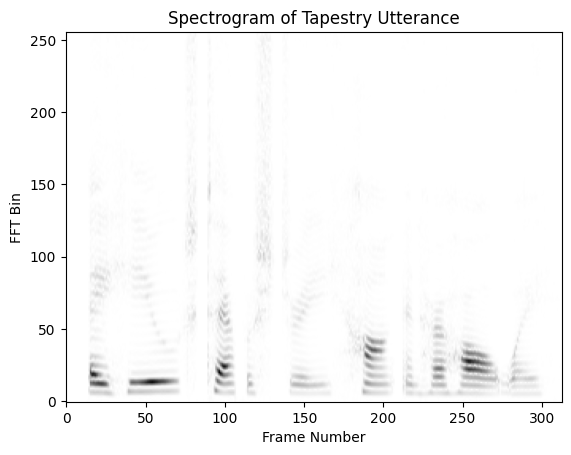

In [41]:
plt.imshow(freqresp, aspect='auto', cmap='gray_r', origin='lower')
plt.xlabel('Frame Number')
plt.ylabel('FFT Bin')
plt.title('Spectrogram of Tapestry Utterance');

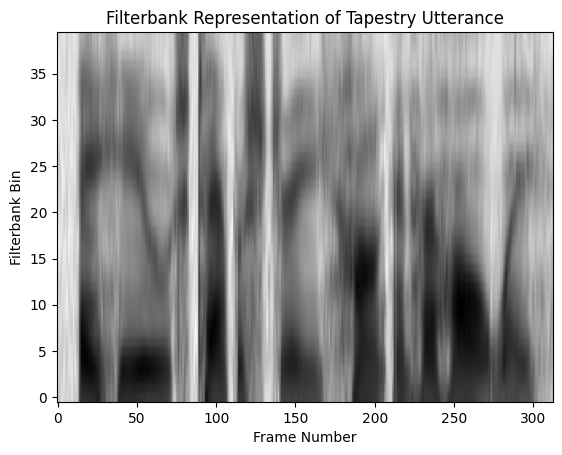

In [42]:
plt.imshow(fbrecon, aspect='auto', cmap='gray_r', origin='lower')
plt.xlabel('Frame Number')
plt.ylabel('Filterbank Bin')
plt.title('Filterbank Representation of Tapestry Utterance');

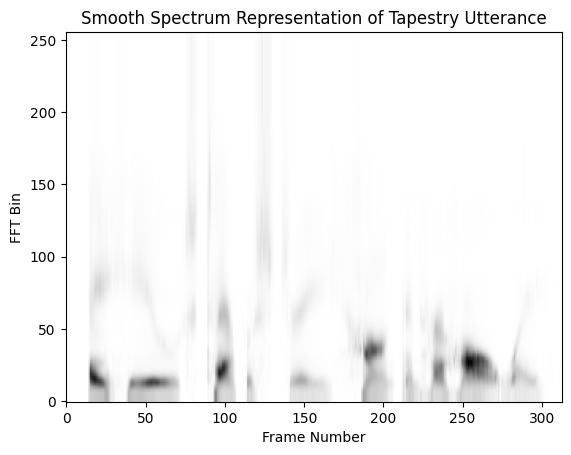

In [43]:
plt.imshow(freqrecon, aspect='auto', cmap='gray_r', origin='lower')
plt.xlabel('Frame Number')
plt.ylabel('FFT Bin')
plt.title('Smooth Spectrum Representation of Tapestry Utterance');

###Correlogram Pitch Model Example

In [44]:
sample_rate = 16000.0
f0 = 2000
tone = np.sin(2*np.pi*f0*np.arange(4000)/sample_rate)
[ceps,freqresp,fb,fbrecon,freqrecon]= pat.Mfcc(tone,sample_rate,100)

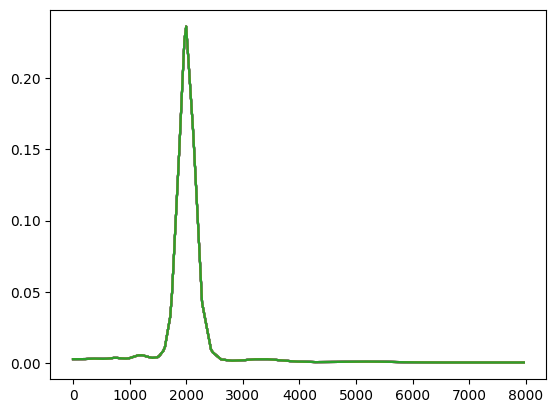

In [45]:
# Make sure the frequency-domain reconstruction has a peak at f0.
fftSize = 512  # From the MFCC source code
freqs = np.arange(fftSize)*sample_rate/fftSize

plt.plot(freqs[:fftSize//2], freqrecon);

In [47]:
# Make sure the spectral peak is in the right bin.
f0/sample_rate*fftSize, np.argmax(np.sum(freqrecon, axis=1))

(64.0, 64)

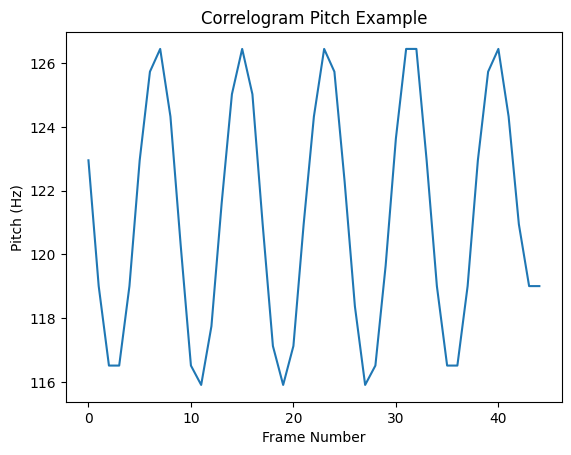

In [48]:
# Generate a vowel with vibrato and make sure the pitch varies as expected.
sample_len = 20000
sample_rate = 22254
u = pat.MakeVowel(sample_len, pat.FMPoints(sample_len, 120), sample_rate, 'u')
n = np.random.randn(sample_len) * np.arange(sample_len)/sample_len
un=u # +n/4

low_freq = 60
num_chan = 100
fcoefs = pat.MakeErbFilters(sample_rate, num_chan, low_freq)
coch= pat.ErbFilterBank(un, fcoefs)
cor = pat.CorrelogramArray(coch,sample_rate,50,256)
[pitch,sal] = pat.CorrelogramPitch(cor,256,22254,100,200)
plt.plot(pitch);
plt.xlabel('Frame Number')
plt.ylabel('Pitch (Hz)')
plt.title('Correlogram Pitch Example');

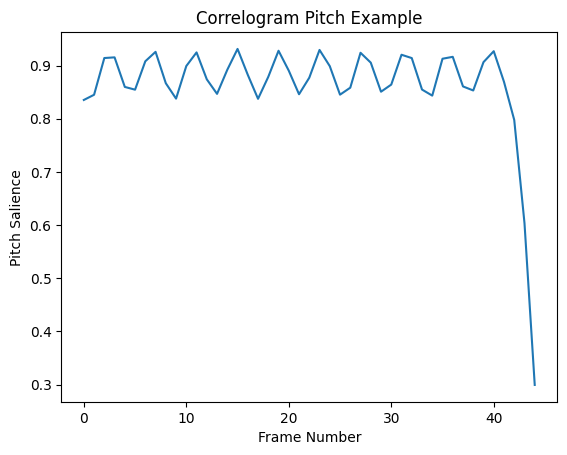

In [49]:
plt.plot(sal);
plt.xlabel('Frame Number')
plt.ylabel('Pitch Salience')
plt.title('Correlogram Pitch Example');

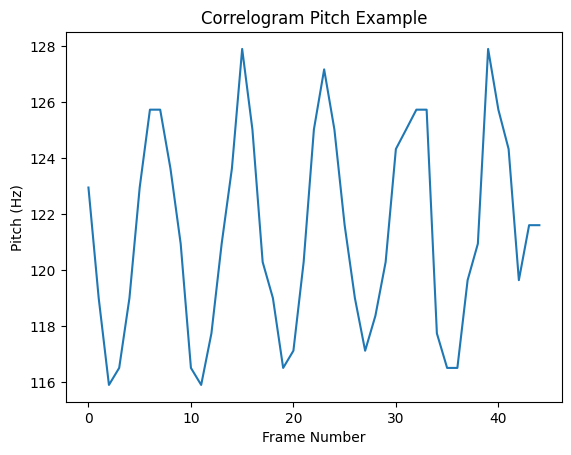

In [50]:
# Generate a vowel with vibrato and make sure the pitch varies as expected.
# This time add noise, linearly increasing in amplitude.
sample_len = 20000
sample_rate = 22254
u = pat.MakeVowel(sample_len, pat.FMPoints(sample_len, 120), sample_rate, 'u')
n = np.random.randn(sample_len) * np.arange(sample_len)/sample_len
un=u + n/4

low_freq = 60
num_chan = 100
fcoefs = pat.MakeErbFilters(sample_rate, num_chan, low_freq)
coch= pat.ErbFilterBank(un, fcoefs)
cor = pat.CorrelogramArray(coch,sample_rate,50,256)
[pitch,sal] = pat.CorrelogramPitch(cor,256,22254,100,200)
plt.plot(pitch);
plt.xlabel('Frame Number')
plt.ylabel('Pitch (Hz)')
plt.title('Correlogram Pitch Example');

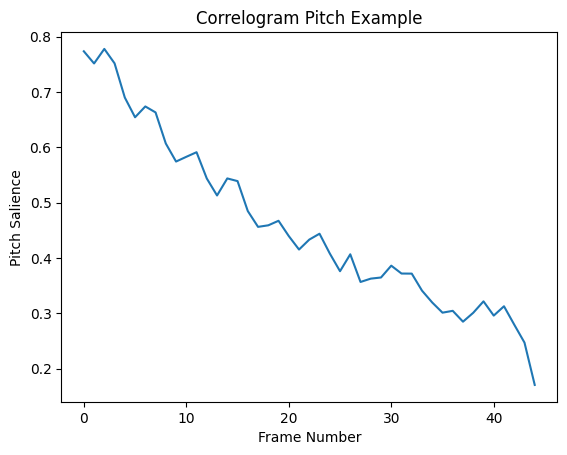

In [51]:
plt.plot(sal);
plt.xlabel('Frame Number')
plt.ylabel('Pitch Salience');
plt.title('Correlogram Pitch Example');

In [52]:
lr = scipy.stats.linregress(range(len(sal)), y=sal, alternative='less')
lr.slope, lr.rvalue

(-0.01152717648259124, -0.9694004470133657)